<a href="https://colab.research.google.com/github/CarlHad333/Non_Verbal_Behaviour/blob/main/Multimodal%20(Audio%20%26%20Text).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#installing a package we'll need for text pre-processing
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.8 MB/s eta 0:00:00


##Importing necessary packages

In [ ]:
#importing necessary packages
import numpy as np
import pandas as pd
import os
import pandas
import librosa
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
import re
import neattext.functions as nfx
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchvision.models as models
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#1- Text data prepping
(same as in notebook Text_classification.ipynb)

In [ ]:
def get_labels(annot_file, file_name):

    f = open(annot_file, 'r').read()
    f = f.split('\n')
    f = f[2:]

    for data in f:

        if len(data) > 0:
            if data[0] == '[':
                data2 = data.split('\t')

                if data2[1] == file_name:
                    emo = data2[2]
                    vad = data2[3][1:-1].split(', ')
                    return emo, [float(x) for x in vad]

    raise ValueError('Label not found')
def get_wav(path):
    '''returns the signal as a tensor + the sample rate'''
    x, sr = librosa.load(path, sr=16000)
    return x, sr

In [ ]:
root_path = '/content/gdrive/MyDrive/IEMOCAP_full_release_withoutVideos_sentenceOnly'

df = pandas.read_csv(os.path.join(root_path, 'iemocap.csv'))

display(df.head())

,Unnamed: 0,session,method,gender,n_annotators,agreement,emotion,valence,activation,dominance,wav_path,MOCAP_rotated_path,MOCAP_head_path,MOCAP_hand_path,FA_ph_path,FA_st_path,FA_sy_path,FA_wd_path
0,0,1,script,F,3,3,neu,2.5,2.0,2.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
1,1,1,script,F,3,2,fru,2.5,2.0,2.5,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
2,2,1,script,F,0,0,xxx,2.0,2.0,2.5,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
3,3,1,script,F,3,2,sur,2.5,3.0,3.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
4,4,1,script,F,3,2,neu,2.0,3.0,3.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...


In [ ]:
def process_files_in_sessions(root_directory, df):
    emotion_dict_all = {}
    session_names = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
    for session_name in session_names:
        text_directory = os.path.join(root_directory, session_name, 'dialog', 'transcriptions')
        wav_directory = os.path.join(root_directory, session_name, 'sentences', 'wav')

        emotion_dict_text = process_text_files_in_directory(text_directory, df)
        emotion_dict_wav = process_wav_files_in_directory(wav_directory, df)

        emotion_dict_all.update(emotion_dict_text)
        emotion_dict_all.update(emotion_dict_wav)
    return emotion_dict_all

def process_text_files_in_directory(directory, df):
    emotion_dict = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                emotion_dict.update(create_emotion_dictionary(file_path, df))
    return emotion_dict

def process_wav_files_in_directory(directory, df):
    emotion_dict = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                emotion = get_emotion_from_df(file_path, df)
                if emotion:
                    emotion_dict[file_path] = emotion
    return emotion_dict

def create_emotion_dictionary(txt_file, df):
    combined_emotion_dict = {}
    with open(txt_file, 'r') as file:
        for line in file:
            parts = line.split(']:', 1)
            if len(parts) == 2:
                replique_id = parts[0].split(' ')[0].strip()
                sentence = parts[1].strip()
                pattern = replique_id.replace('[', '').replace(']', '') + r'.wav'
                row = df[df['wav_path'].str.contains(pattern)]
                if not row.empty and sentence:
                    emotion = row['emotion'].iloc[0]
                    agreement = row['agreement'].iloc[0]
                    if emotion != 'xxx' and agreement >= 2:
                        combined_emotion_dict[(row['wav_path'].iloc[0], sentence)] = emotion
    return combined_emotion_dict

def get_emotion_from_df(file_path, df):
    row = df[df['wav_path'] == file_path]
    if not row.empty:
        return row['emotion'].iloc[0]
    return None


In [ ]:
root_path = '/content/gdrive/MyDrive/IEMOCAP_full_release_withoutVideos_sentenceOnly/IEMOCAP_full_release/'
emotion_dict_all = process_files_in_sessions(root_path, df)

In [ ]:
import pandas as pd

# Assuming emotion_dict_all contains your emotion dictionary

# Initialize an empty list to store DataFrames for each entry
data = []

# Iterate over each item in the emotion dictionary
for key, emotion in emotion_dict_all.items():
    # Extract wav_path and sentence from the key tuple
    if len(key) != 2:
      print(key)
    wav_path, sentence = key

    # Extract session number from the wav path
    session_number = wav_path.split('/')[1].replace('Session', '')  # Extract session number

    # Create a DataFrame for the current entry
    entry_df = pd.DataFrame({
        'Session': session_number,
        'Sentence': sentence,
        'wav_path': wav_path,
        'emotion': emotion
    }, index=[0])  # Create DataFrame with single row

    # Append the DataFrame to the list
    data.append(entry_df)

# Concatenate all entry DataFrames into one DataFrame
final_data = pd.concat(data, ignore_index=True)

# Optional: Perform text cleaning
final_data['Clean_Text'] = final_data['Sentence'].apply(nfx.remove_userhandles)
final_data['Clean_Text'] = final_data['Clean_Text'].apply(nfx.remove_stopwords)

In [ ]:
selected_emotions = ['neu', 'ang', 'exc', 'sad', 'hap']
final_data_filtered = final_data[final_data['emotion'].isin(selected_emotions)].copy()

# Replace 'exc' with 'hap'
final_data_filtered.loc[final_data_filtered['emotion'] == 'exc', 'emotion'] = 'hap'
final_data_filtered.emotion.value_counts()

neu    1708
hap    1636
ang    1103
sad    1084
Name: emotion, dtype: int64

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming final_data_filtered contains your DataFrame

# Define the number of samples to select from each class
num_samples_per_class = 1084

# Group the data by 'emotion' and sample randomly from each group
balanced_data = final_data_filtered.groupby('emotion', group_keys=False).apply(lambda x: x.sample(min(len(x), num_samples_per_class)))

# Reset index
balanced_data.reset_index(drop=True, inplace=True)

# Encode the 'emotion' column to numeric labels
LE = LabelEncoder()
balanced_data['label'] = LE.fit_transform(balanced_data['emotion'])

# Display the value counts to ensure balance
print(balanced_data['emotion'].value_counts())

ang    1084
hap    1084
neu    1084
sad    1084
Name: emotion, dtype: int64


In [ ]:
balanced_data.head()

,Session,Sentence,wav_path,emotion,Clean_Text,label
0,2,Turn it off. It's driving me mad.,IEMOCAP_full_release/Session2/sentences/wav/Se...,ang,Turn off. driving mad.,0
1,3,"Augie, Goddamn it, don't ask me that. You alwa...",IEMOCAP_full_release/Session3/sentences/wav/Se...,ang,"Augie, Goddamn it, ask that. ask that. ask tha...",0
2,3,What? There- There's hundreds of thousands of ...,IEMOCAP_full_release/Session3/sentences/wav/Se...,ang,What? There- There's hundreds thousands dollar...,0
3,4,"Really, you don't work for anybody. It's just...",IEMOCAP_full_release/Session4/sentences/wav/Se...,ang,"Really, work anybody. you?",0
4,3,"That's a nice point of view, I must say.",IEMOCAP_full_release/Session3/sentences/wav/Se...,ang,"That's nice point view, say.",0


In [ ]:
#Session 1,2,3,4 for train, 5 for test
#train_data = balanced_data[balanced_data['Session'].isin(['1', '2', '3', '4'])]
#test_data = balanced_data[balanced_data['Session'] == '5']

In [ ]:
train_data, test_data = train_test_split(balanced_data, test_size=0.2, random_state=42)

In [ ]:
train_data.emotion.value_counts()

neu    880
sad    875
hap    863
ang    850
Name: emotion, dtype: int64

In [ ]:
# Step 1: Text Data Processing
tfidf_vectorizer = TfidfVectorizer()
X_train_text = tfidf_vectorizer.fit_transform(train_data['Clean_Text'])
X_test_text = tfidf_vectorizer.transform(test_data['Clean_Text'])

#2- Audio data pre-processing

In [ ]:
#Functions for Pre-processing of .wav files

def get_wav(path):
    '''returns the signal as a tensor + the sample rate'''
    x, sr = librosa.load(path, sr=16000)
    return x, sr

def extract_mfcc(audio_data, sample_rate):
    # Extract MFCC (Mel-frequency cepstral coefficients) features
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)

    # Calculate the mean of MFCC coefficients across time
    mfccs_mean = np.mean(mfccs, axis=1)

    # Calculate the standard deviation of MFCC coefficients across time
    mfccs_std = np.std(mfccs, axis=1)

    # Concatenate mean and standard deviation to create feature vector
    audio_features = np.concatenate((mfccs_mean, mfccs_std)) #shape (26,)

    return audio_features

In [ ]:
train_data.emotion.value_counts()

neu    880
sad    875
hap    863
ang    850
Name: emotion, dtype: int64

In [ ]:
#Step 2 : Audio data Processing
root_path = '/content/gdrive/MyDrive/IEMOCAP_full_release_withoutVideos_sentenceOnly/'

X_train_audio = []
X_test_audio = []
train_labels = []
test_labels = []
for index, row in train_data.iterrows():

    # Audio data
    x, sr = get_wav(os.path.join(root_path, row['wav_path']))
    # Extract mfcc from audio data
    audio_features = extract_mfcc(x, sr)
    # Get emotion label
    _, file_name = os.path.split(row['wav_path'])
    annot_file = os.path.join(root_path, 'IEMOCAP_full_release',
                              'Session'+str(row['Session']),
                              'dialog', 'EmoEvaluation',
                              file_name[:-9] + '.txt')
    emo, _ = get_labels(annot_file, file_name[:-4])
    if emo != 'exc':
    # Append features and labels
      X_train_audio.append(audio_features)
      train_labels.append(emo)
    if emo == 'exc':
      X_train_audio.append(audio_features)
      train_labels.append('hap')


#test data
for index, row in test_data.iterrows():
    # Audio data
    x, sr = get_wav(os.path.join(root_path, row['wav_path']))
    # Extract mfcc from audio data
    audio_features = extract_mfcc(x, sr)

    # Get emotion label
    _, file_name = os.path.split(row['wav_path'])
    annot_file = os.path.join(root_path, 'IEMOCAP_full_release',
                              'Session'+str(row['Session']),
                              'dialog', 'EmoEvaluation',
                              file_name[:-9] + '.txt')
    emo, _ = get_labels(annot_file, file_name[:-4])

    # Append features and labels
    if emo == 'exc':
      X_test_audio.append(audio_features)
      test_labels.append('hap')
    if emo != 'exc':
      X_test_audio.append(audio_features)
      test_labels.append(emo)

In [ ]:
print(len(X_train_audio))
print(X_train_text.shape)


3468
(3468, 2226)


#Merging the 2 modalities (Audio & Text)

##Classifier 1: Logistic regression

In [21]:
from scipy.sparse import hstack

# Combine features
X_train_combined = hstack((X_train_audio, X_train_text))

# Logistic Regression for combined features
combined_model = LogisticRegression(max_iter=10000)
combined_model.fit(X_train_combined, train_labels)

# Evaluate the model
X_test_combined = hstack((X_test_audio, X_test_text))
predictions_combined_lr = combined_model.predict(X_test_combined)
accuracy_combined = accuracy_score(test_labels, predictions_combined_lr)
print(f'Combined model accuracy: {accuracy_combined:.4f}')

Combined model accuracy: 0.7512


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


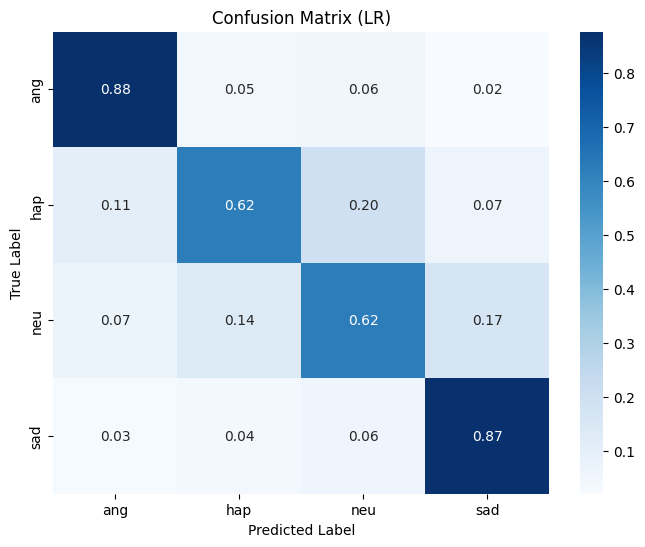

In [22]:
#Corresponding confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_combined_lr)
# Normalize confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.title("Confusion Matrix (LR)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##Classifier 2 : MLP

In [23]:
mlp_classif = MLPClassifier(hidden_layer_sizes=(32, 16, 8), activation='relu', solver='adam',
                               max_iter=100, tol=1e-4, random_state=42)
mlp_classif.fit(X_train_combined, train_labels)

# Evaluate the model
X_test_combined = hstack((X_test_audio, X_test_text))
predictions_combined_mlp = mlp_classif.predict(X_test_combined)
accuracy_combined = accuracy_score(test_labels, predictions_combined_mlp)
print(f'Combined model accuracy: {accuracy_combined:.4f}')

Combined model accuracy: 0.7385


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


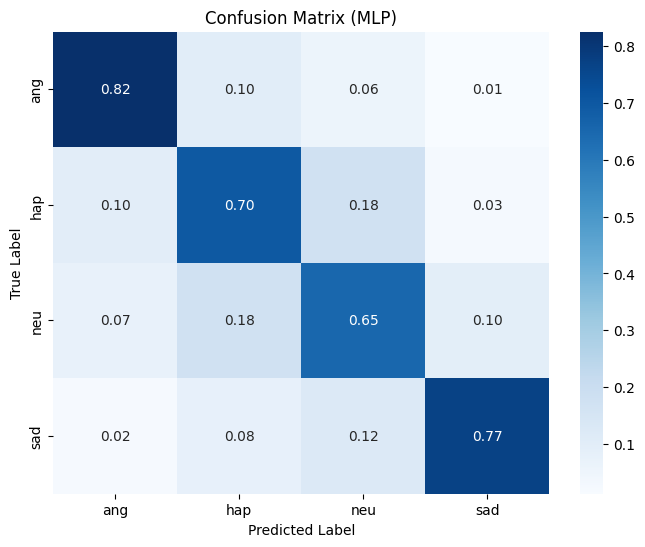

In [24]:
#Corresponding confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_combined_mlp)
# Normalize confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.title("Confusion Matrix (MLP)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##Classifier 3 : Random Forest

In [25]:
rf_classif = RandomForestClassifier(n_estimators=3000)
rf_classif.fit(X_train_combined, train_labels)

# Evaluate the model
X_test_combined = hstack((X_test_audio, X_test_text))
predictions_combined = rf_classif.predict(X_test_combined)
accuracy_combined = accuracy_score(test_labels, predictions_combined)
print(f'Combined model accuracy: {accuracy_combined:.4f}')

Combined model accuracy: 0.6901


##Classifier 4 : Gradient boost

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize Gradient Boosting Classifier
gb_classif = GradientBoostingClassifier(n_estimators=1800)

# Fit the model
gb_classif.fit(X_train_combined, train_labels)
# Make predictions
predictions_combined_gb = gb_classif.predict(X_test_combined)
# Evaluate the model
accuracy_combined = accuracy_score(test_labels, predictions_combined_gb)
print(f'Combined model accuracy: {accuracy_combined:.4f}')


Combined model accuracy: 0.7362


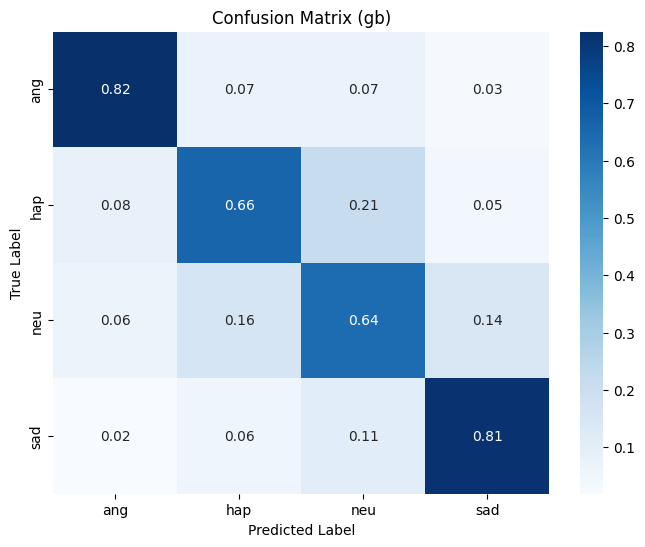

In [27]:
#Corresponding confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_combined_gb)
# Normalize confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.title("Confusion Matrix (gb)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()